# K-means clustering

It should not surprise you at this point to learn that doing unsupervised learning in scikit-learn is pretty easy (which is not to say that doing it *well* is easy, of course). The code looks almost exactly the same is it does in the unsupervised setting. The main difference is that unsupervised learning estimators take only `X` data—there is, by definition, no set of labels `y`.

Let's cluster the observations in the above plot using the [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) algorithm:

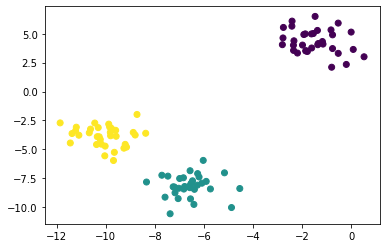

In [22]:
from sklearn.cluster import KMeans

kmc = KMeans(3)
kmc.fit(X)

colors = kmc.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=colors);

# Job well done?

At this point we've developed fully operational machine learning workflows for three separate kinds of machine learning problems: regression, classification, and clustering. Relatively little work was involved in each case. In the case of the regression problem, for example, we initialized a linear regression model, fit it to some data, used it to generate predictions, and scored those predictions— all in 3 or 4 lines of code! This seems pretty great. Maybe we should just stop here, pat ourselves on the back for a job well done, and head home for the day.

For reasons that will shortly become clear, though, calling it quits here would be a really bad idea.

Let's dig a little deeper. We'll start by asking an important question that echoes back to the definition of machine learning as the study of systems that can improve their output by learning from experience. Specifically: how does our model's performance evolve as we give it more data?

Think back to our (continuous) age prediction problem. Intuitively, we might expect that our $R^2$ will go up as we increase the size of our dataset (because having more data to learn from seems like it should be a good thing). But we should probably verify that.

Instead of fitting our `LinearRegression` estimator to just one dataset, let's systematically vary our sample size over a large range, and fit a linear regression to each one (actually, to stabilize our performance estimates, we'll average over multiple permutations at each sample size).

The code below is much more involved than it needs to be; as we'll see in the next section, scikit-learn includes a number of utilities that can achieve the same goal much more compactly and efficiently. But I think it can be helpful to explicitly lay out all of the steps we're going through before we replace them with a single line of black magic.

In [23]:
# initialize the OLS estimator
est = LinearRegression()

# we'll plot a separate panel for each feature set
feature_sets = ['domains', 'facets', 'items']

# evaluate performance at each of these sample sizes
sample_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]

# number of permutations to average over at each sample size
n_reps = 10

# store results for all permutations, sample sizes, and feature sets
results = np.zeros((n_reps, len(sample_sizes), len(feature_sets)))

# loop over permutations
for i in range(n_reps):
    # loop over sample sizes
    for j, n in enumerate(sample_sizes):
        # get the appropriate features and labels
        *Xs, age = get_features(data, *feature_sets, 'AGE', n=n)
        # loop over feature sets
        for k, X in enumerate(Xs):
            # fit the model
            est.fit(X, age)
            # generate predictions
            pred_y = est.predict(X)
            # save R^2 in our results array
            results[i, j, k] = r2_score(age, pred_y)

# Compute means and stdevs for error bars 
r2_mean = results.mean(0)
r2_std = results.std(0)

Now we can plot the resulting $R^2$ values for each feature set as a function of sample size:

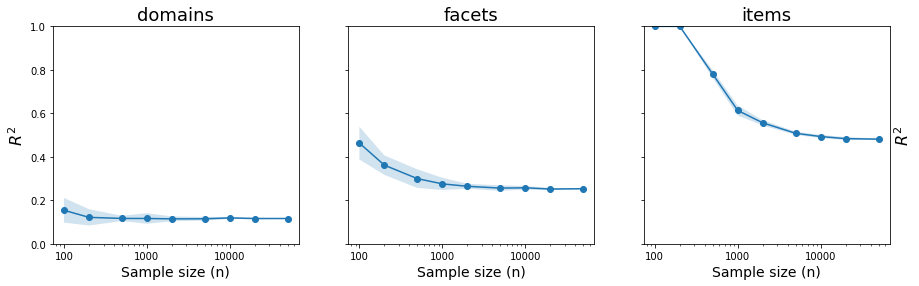

In [24]:
# used to display axis tick labels on a linear scale
from matplotlib.ticker import ScalarFormatter

# Set up plots=
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
plt.ylim(0, 1)

# Plot results
for i, label in enumerate(feature_sets):
    mean, sd = r2_mean[:, i], r2_std[:, i]
    ax = axes[i]
    line = ax.plot(sample_sizes, mean, 'o-')
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel("Sample size (n)", fontsize=14)
    ax.fill_between(sample_sizes, mean-sd, mean+sd, alpha=0.2)
    ax.set_title(label, fontsize=18)

# Add y-axis labels on both sides
axes[0].set_ylabel("$R^2$", fontsize=16);
axes[-1].set_ylabel('$R^2$', fontsize=16)
axes[-1].yaxis.set_label_position("right")

Here, each panel displays the model's ability to predict (on the y-axis) as a function of sample size (x-axis). Each panel displays results for a different set of predictive features: at left, we have the 5 domains; in the middle, the 30 facets; and at right, the 300 items. This gives us some insight into how model performance varies as we add more features—something we'll discuss in much more detail in the next couple of notebooks.

For now, let's focus on the dominant pattern we see within each of the panels. Strangely, it looks like model performance *decreases* with increasing sample size! You may find this odd, seeing as everyone's always talking about the wonders of Big Data, and intuitively, you might think that having more information available would lead the model to make *better* predictions.

Actually, the model probably *is* making better predictions when it has more data to learn form. It just doesn't look that way. The problem is not what's happening on the right side of the curve, but what's happening on the left side (i.e., when sample size is small). On the left, the model is *overfitting* the data. Because there are very few data points, and our model is extremely flexible (it has 300 degrees of freedom with which to predict only a few hundred points!), there's nothing to stop the model from learning noise rather than signal. As the sample size grows, the data provide a natural buffer against this kind of thing. We'll explore this idea in much more detail in the next couple of sections.